<h1 align='center'> FEniCS Thermal Transport in TiAl$_2$O$_3$ Cylindrical Geometry </h1>
<center>
Nicholas Goldring <br>
Dan Abell <br>
Boaz Nash <br>
RadiaSoft LLC <br>
November 2022 <br>

***
## Notes
***


model diagram

<img src="figures/crystal_diagram01.PNG">

<!-- $
hse = T_0 + T_1 \left( e^{-\frac{z + l/2}{0.3l}} + e^{\frac{z - l/2}{0.3l}} \right) e^{-\frac{1}{2} {\left(\frac{x^2 + y^2}{w^2} \right)}^{p_x} }
$ -->

<!-- $x, \hspace{1mm} y, \hspace{1mm} z$ : spatial coordinates [cm] \
$T_0$ : temperature input at time = 0s [$^\circ$C] \
$T_1$ : temperature input at time of incident heat load [$^\circ$C] \
$l$ : crystal length [cm] \
$w^2$ : variance [cm$^2$] \
$p_x$ : x-component of Super Gaussian exponent -->

***
$\textbf{Imports and definitions}$
***

In [1]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import norm
import time as tm
import copy
import warnings
from IPython.display import Latex

from fenics import*
from mshr import*

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
hfontLarge = {'fontname':'Latin Modern Roman', 'size' : 24, 'weight' : 'bold'}
hfontMed = {'fontname':'Latin Modern Roman', 'size' : 19, 'weight' : 'bold'}
hfontMed2 = {'fontname':'Cambria', 'size' : 19, 'weight' : 'bold'}


***
$\textbf{Create and mesh geometry}$

In [2]:
# geometry dimensions
leng = 2.5  # cylinder length [cm]
diam = 1.0  # cylinder diameter [cm]

# derived parameters
rad = diam / 2    # radius [cm]
lh = leng / 2     # half-length [cm]
rad2 = rad * rad  # radius squared [cm^2]


# create a cylindrical geometry
# cylinder = Cylinder('coordinate of center of the top circle', 'coordinate of center of the bottom circle', 'radius of the circle at the top', 'radius of the circle at the bottom')
cylinder = Cylinder(Point(0, 0, lh), Point(0, 0, -lh), rad, rad)
# cylinder = Cylinder(Point(0, 0, 2*lh), Point(0, 0, 0*(-lh)), rad, rad)
geometry = cylinder

# define mesh
mden = 35  # 60  # 45  # mesh density
mesh = generate_mesh(geometry, mden)

# save the mesh
File("cylinder.pvd") << mesh
print('rad: %s cm' %(rad))

Generating mesh with CGAL 3D mesh generator
rad: 0.5 cm


In [3]:
# plot mesh
print('Geometry')
print('length: %s cm, radius: %s cm' %(leng, rad))
print('Mesh')
print('mesh density: %s, no. of tetrahedral elements: %s, no. of vertices: %s' %(mden, mesh.num_cells(), mesh.num_vertices()))
mesh

Geometry
length: 2.5 cm, radius: 0.5 cm
Mesh
mesh density: 35, no. of tetrahedral elements: 19431, no. of vertices: 3762


***
$\textbf{Define boundary and initial conditions, sources}$

In [4]:
# constants
T0 =  0.0        # deg C : T_0
# dT    = 20.0   # deg C : T_1 - used in earlier heat load expressions
# wdT   = 0.25   # laser radius [cm] (1/2 crystal radius)
# wdT = 0.162    # laser radius [cm] - calculated via w_p = sqrt(2) * c_1
wdT = 0.055      # laser radius [cm] - BELLA pump laser radius (1.1 mm diameter)
# ldT   =  0.40  # cm
# sg_px = 8      # 1 : x-component of super gaussian exponent
# sg_py = 1      # 1 : y-component of super gaussian exponent
# rad_ratio_sq = (rad**2) / (wdT**2)
# log_rrsq = np.log(rad_ratio_sq)
# print('log of square of radius ratio: %s' %(log_rrsq))

# define function space on mesh
V = FunctionSpace(mesh, 'P', 1)

# define Dirichlet boundary condition for sides at r_max
tol = 1.e-13
def boundary_D(x, on_boundary):
    return on_boundary and near(x[0]*x[0] + x[1]*x[1], rad2, tol)
bc = DirichletBC(V, Constant(T0), boundary_D)

# Gaussian (BELLA pump laser)
pix_to_deg = 6.9                  # pix to micron ratio 1 pixel/6.9 micron  <formerly 1 pixel/6.9 micron>
# a1 = 3.84e4                     # Gaussian amplitude
b1 = 0.0   # 361.5
c1 = 166.0 * pix_to_deg / 1e4     # variance [cm]
print('variance, c1: %s [cm]' %(c1))

# absorption length inferred from Chenais paper: alpha = ~0.4 1/cm
# absorption length for BELLA pi-polarized pump: 1.2 1/cm  (95.5% absorption)
# absorption length for BELLA sigma-polarized pump: 0.58 1/cm (76.5% absorption)
alpha_h = 1.2           # absorption length [1/cm]

# calculate incremental temperature deposition
PumpPower = 20                                                      # pump laser power [W]
P_abs = PumpPower * (800 - 532) / 800                               # absorbed power [W]  (previously used 35 * 2 in top hat heat load)
print('Absorbed power: %f [W]' %(P_abs))
# V_abs = np.pi * (wdT/100)**2 * (leng/100)                         # absorption volume [m^3]  (1/100 to convert cm to m)
V_eff = np.pi * c1**2 * (1 - np.exp(-alpha_h * leng)) / alpha_h     # effective volume [cm^3]
K_c_tisaph = 33/100                                                 # thermal conductivity [W/cm/K]    https://www.rp-photonics.com/titanium_sapphire_lasers.html
K_c_calc = 0.31                                                     # thermal conductivity [W/cm/K] inferred from experimental delta T and Innocenzi eqn (7)
K_c_bella = 0.27                                                    # thermal conductivity [W/cm/K] BELLA horizontal polarization
K_c_ndyag = 0.1                                                     # thermal conductivity of Nd:YAG [W/cm/K]
K_c_vd = 0.23                                                       # thermal conductivity [W/cm/K] (perpendicular) of Sapphire @ 23 [degC] according to Valley Design
rho_tisaph = 3.98                                                   # density of Ti:Sapphire [gm/cm^3]
rho_ndyag = 4.56                                                    # density of Nd:YAG [gm/cm^3]
# rho = rho_ndyag   
rho = rho_tisaph
c_p_tisaph = 0.756                                                  # specific heat of Ti:Sapphire [J/gm/K]
c_p_vd = 0.756                                                      # specific heat of Sapphire according to Valley Design
c_p_calc = 0.267                                                    # specific heat of Ti:Sapphire [J/gm/K] inferred from thermal diffusivity via the experimental thermal time constant (150 ms)
c_p_ndyag = 0.59                                                    # specific heat of Nd:YAG [J/gm/K]
# c_p = c_p_ndyag                                                   
# c_p = c_p_tisaph
c_p = c_p_calc

# dQ_incr = P_abs / V_abs             # incremental heat deposition [W/cm^3]
dQ_incr = P_abs / V_eff               # incremental heat deposition [W/cm^3]
dT_incr = dQ_incr / rho / c_p         # incremental temperature deposition [K/s]

print('dQ_incr: %f [W/cm^3], dT_incr: %f [K/s]' %(dQ_incr, dT_incr))

variance, c1: 0.11454 [cm]
Absorbed power: 6.700000 [W]
dQ_incr: 205.291459 [W/cm^3], dT_incr: 193.186400 [K/s]


In [5]:
(800-532)/800

0.335

***
**Define heat load expression**

In [6]:
# define heat load expressions
gsn_bella_heat_load = Expression('dT * exp( -(pow((x[0] - b1) / c1, 2) + pow((x[1] - b1) / c1, 2)) ) * exp(-alpha_h * (x[2] + lh))',
                                 degree = 1, dT = dT_incr, b1 = b1, c1 = c1, alpha_h = alpha_h, lh = lh)

# gsn_bella_heat_load = Expression('dT * exp( -(pow((x[0] - b1) / c1, 2) + pow((x[1] - b1) / c1, 2)) ) * exp(-alpha_h * x[2])',
#                                  degree = 1, dT = dT_incr, b1 = b1, c1 = c1, alpha_h = alpha_h)

# # exp(decay) x Super Gaussian
# expsg_heat_load = Expression('T0 + dT * (exp(-(x[2]+l/2)/dl) + exp((x[2]-l/2)/dl)) \
#                     * exp(-0.5 * pow((x[0]*x[0] + x[1]*x[1])/(w*w), px))',
#                  degree=1, T0=T0, dT=dT_incr, w=wdT, l=leng, dl=0.3*leng, px=sg_px)

# uniform top-hat
uniform_heat_load = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)',
                   degree=1, dT=dT_incr, w=wdT)

# z-dependent heat load with abs. length
# long_abs_heat_load = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)*(alpha_h*exp(-alpha_h*x[2]) / (1 - exp(-alpha_h*leng)))',
#                    degree=1, alpha_h=alpha_h, leng=leng, dT=dT_incr, w=wdT)

long_abs_heat_load = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)*(exp(-alpha_h*x[2]))',
                   degree=1, alpha_h=alpha_h, leng=leng, dT=dT_incr, w=wdT)

# # chenais top-hat w/ absorption coefficient term and log term
# chenais_heat_load_logterm = Expression('dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0) * (exp(-alpha_h*x[2]) / (1 - exp(-alpha_h*leng))) * log_rrsq',
#                    degree=1, alpha_h=alpha_h, leng=leng, dT=dT_incr, log_rrsq=log_rrsq, w=wdT)

#test_cpp_func01 = Expression('(alpha_h*exp(alpha_h) / (1 - exp(alpha_h)))', degree=1, alpha_h=alpha_h, dT=dQ, w=wdT)

# # T0 + dT x Θ(w–r)
# # standard cylinder running length of crystal with given radius
# # Heaviside theta function: 1 everywhere argument is positive, 0 everwhere argument is negative
# # Vary radius (w^2) - rate of decay.  Try double size of w  
# bolus = Expression('T0 + dT * ((x[0]*x[0] + x[1]*x[1])/(w*w) < 1 ? 1 : 0)',
#                    degree=1, T0=T0, dT=dT, w=wdT)

# define initial value
# u_n = interpolate(uniform_heat_load, V)
# u_n = interpolate(bolus, V)
# u_n = interpolate(hse, V)
u_n = interpolate(Constant(T0), V)

# tol = 1e-2  # originally set to 1e-2 by Dan
tol = 2e-2
u_min = u_n(rad-tol, 0., 0.)
u_max = u_n(0., 0., lh-tol)
#print(u_min, u_max)
u_n(rad-tol, 0., 0.), u_n(0., 0., lh-tol)
#print(u_min, u_max)

(0.0, 0.0)

In [7]:
print(Expression('x[0]',
                degree = 1))

f_17


In [8]:
# define crystal properties

a_Al2O3 = 7.98e-2  # cm^2/s diffusion constant of sapphire (Al2O3): (thermal conductivity [W/cm/K] / rho [gm/cm^3] / specific heat capacity(J/gm/K))
a_perp  = 7.64e-2  # perpendicular to C
a_para  = 8.57e-2  # parallel to C

a_tisaph = K_c_tisaph / c_p_tisaph / rho_tisaph  
a_ndyag = K_c_ndyag / c_p_ndyag / rho_ndyag
a_calc = K_c_calc / c_p_calc / rho_tisaph
a_vd = K_c_vd / c_p_vd / rho_tisaph
a_bella_vd = K_c_bella / c_p_vd / rho_tisaph

# a_crystal = a_ndyag
# a_crystal = a_tisaph
# a_crystal = a_tisaph * 2.5
a_crystal = a_calc
# a_crystal = a_vd
# a_crystal = a_bella_vd
# a_crystal = a_tisaph * 1.0
# a_crystal = 0.69   # 0.5

print('a_tisaph: %s [cm^2/s]' %a_tisaph)
print('a_ndyag: %s [cm^2/s]' %a_ndyag)

print('K_c_calc: %s [W/cm/K]' %K_c_calc)
print('c_p_calc: %s [J/gm/K]' %c_p_calc)
print('a_calc: %s [cm^2/s]' %a_calc)

print('a_crystal: %s [cm^2/s]' %a_crystal)

a_tisaph: 0.10967536093164235 [cm^2/s]
a_ndyag: 0.03716919417187036 [cm^2/s]
K_c_calc: 0.31 [W/cm/K]
c_p_calc: 0.267 [J/gm/K]
a_calc: 0.29172077616547154 [cm^2/s]
a_crystal: 0.29172077616547154 [cm^2/s]


***
### Evolve function
**Define simulation time stepping**

Variational formulation \
*A straightforward approach to solving time-dependent PDEs by the finite
element method is to first discretize the time derivative by a finite difference
approximation, which yields a sequence of stationary problems, and then turn
each stationary problem into a variational formulation.*

In [9]:
# define time stepping
T = 1.5e1          # total simulation time [s]
# n_steps = 1000     # number of time steps
n_steps = 1000     # number of time steps
dt = T / n_steps   # size of time step [s]
# nip = 20           # number of intervals between records
nip = 2           # number of intervals between records
print('dt: %s s' %dt)

# define variational problem
u = TrialFunction(V)
v = TestFunction(V)

# source term 
f = gsn_bella_heat_load           # Gaussian heat load for BELLA pump laser
# f = Constant(0)                 # no source term
# f = uniform_heat_load           # uniform cylindrical heat load
# f = long_abs_heat_load          # Chenais heat load formula (2.1.6) without log term
# f = chenais_heat_load_logterm   # chenais heat load eqn. 2.1.6 with log term
# f = bolus                       # source term bolus
# f = expsg_heat_load             # source term hse

# F = u*v*dx + dt*a_Al2O3*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx + gi*v*ds  # w/ Neumann BC
# F = u*v*dx + dt*a_crystal*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx  # w/ Dirichlet + initial condition
F = u*v*dx + dt*a_crystal*dot(grad(u), grad(v))*dx - (u_n + dt*f)*v*dx  # w/ Dirichlet + initial condition
a, L = lhs(F), rhs(F)


def evolve():

    # g_src = gsn_bella_heat_load
    
    # time-stepping
    u = Function(V)
    t = 0
    
    # report initial state
    yield u_n, t

    # source_on = True
    # eom_set = False
    
    for n in range(1, n_steps + 1):

        # update current time
        t += dt
        
        # uncomment below to switch off pump laser at t = t_off [s]    
        # if t_off < t:
        #     # print('turning off source')
        #     gsn_bella_heat_load.dT = 0.  
            
        # print('t: %s [s], gsn_bella_heat_load: %s' %(t, assemble(gsn_bella_heat_load*dx(domain=mesh))) )
        
        # compute solution
        set_log_level(30)
        solve(a == L, u, bc)

        # report current state
        if n % nip == 0:
            yield u, t

        # update previous solution
        u_n.assign(u)

# # define time-evolution function
# def evolve():

#     # g_src = gsn_bella_heat_load
    
#     # report initial state
#     yield u_n

#     # time-stepping
#     u = Function(V)
#     t = 0
#     # source_on = True
#     # eom_set = False
    
#     for n in range(1, n_steps + 1):

#         # update current time
#         t += dt
#         # if eom_set == False:
#         #     F = u*v*dx + dt*a_crystal*dot(grad(u), grad(v))*dx - (u_n + dt*gsn_bella_heat_load)*v*dx  # w/ Dirichlet + initial condition
#         #     a, L = lhs(F), rhs(F)
#         #     eom_set = True
        
#         # uncomment below to switch off pump laser at t = t_off [s]
#         # print('t_off: %s [s], t: %s [s]' %(t_off, t))
#         # if source_on == True and t_off < t:
#         #     source_on = False
#         #     # print('turning off source')
#         #     gsn_bella_heat_load.dT = 0.     
            
#         if t_off < t:
#             # print('turning off source')
#             gsn_bella_heat_load.dT = 0.  
            
#         # print('t: %s [s], gsn_bella_heat_load: %s' %(t, gsn_bella_heat_load))
            
#         # compute solution
#         set_log_level(30)
#         solve(a == L, u, bc)

#         # report current state
#         if n % nip == 0:
#             yield u

#         # update previous solution
#         u_n.assign(u)

dt: 0.015 s


***
$\textbf{Define facets, coordinates for extracting data and plotting}$

In [10]:
# for 3D plots, get the facets, and build an array
# containing the indices of their coordinates
inds = []
for item in dolfin.cpp.mesh.facets(mesh):
    inds.append(item.entities(0).tolist())

# we will provide these indices to plotly so it can draw proper surfaces
inds = np.array(inds)
ii = inds[:, 0]
jj = inds[:, 1]
kk = inds[:, 2]

# get node coördinate values and ranges
xvals = mesh.coordinates()[:,0]
yvals = mesh.coordinates()[:,1]
zvals = mesh.coordinates()[:,2]
xmin, xmax = xvals.min(), xvals.max()
ymin, ymax = yvals.min(), yvals.max()
zmin, zmax = zvals.min(), zvals.max()

***
$\textbf{Execute simulation}$

mesh density: 35, no. of tetrahedral elements: 19431, no. of vertices: 3762
simulation time: 2.252 minutes


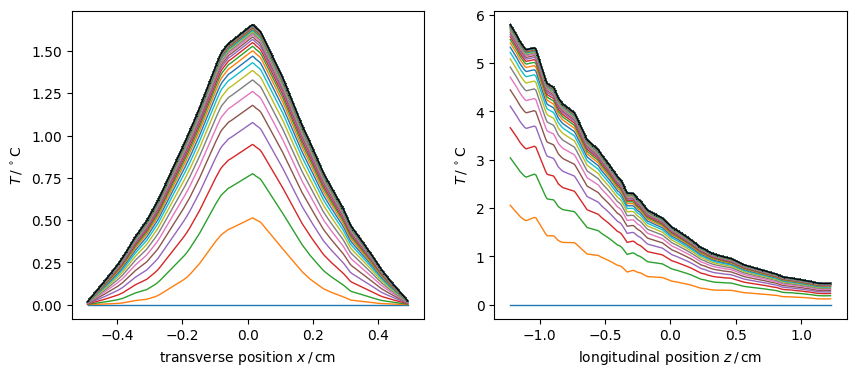

In [11]:
n_rows = 1
n_cols = 2
# fig_wd = 15
# default sizing here yields unit aspect ratio
# plt.figure(figsize = (fig_wd, fig_wd * n_rows // n_cols))
# plt.subplot(n_rows, n_cols, idx)

fig = plt.figure(figsize=(10,4))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

tol = 2.e-2  # avoid points outside domain (for a coarse mesh, increase this value) - already defined above
xv = np.linspace(xmin * (1 - tol), xmax * (1 - tol), 201)
zv = np.linspace(zmin * (1 - tol), zmax * (1 - tol), 201)
radpts = [(x_, 0, 0) for x_ in xv]
axipts = [(0, 0, z_) for z_ in zv]

# define laser shut-off time [s]
t_off = 5.0     # 2.5 0.25, 5.0

idx = 0   # number of time steps to complete simulation, idx*dt will yield final simulation time

T_center = []
T_entrance = []
T_exit = []
t_vals = []

t0 = tm.time()
for u, curr_t in evolve():
    idx += 1
    ux = np.array([u(pt) for pt in radpts])
    uz = np.array([u(pt) for pt in axipts])
    # fig1.plot(xv, ux, lw=1, label='{0:5.3f} s'.format(idx*dt))  
    fig1.plot(xv, ux, lw=1)  
    fig2.plot(zv, uz, lw=1)
    T_center.append(u(0, 0, 0))
    T_entrance.append(u(0, 0, zv[0]))
    T_exit.append(u(0, 0, zv[200]))
    t_vals.append(curr_t)
# for u in evolve():
#     idx += 1
#     ux = np.array([u(pt) for pt in radpts])
#     uz = np.array([u(pt) for pt in axipts])
#     fig1.plot(xv, ux, lw=1, label='{0:5.3f} s'.format(idx*dt))  
#     fig2.plot(zv, uz, lw=1)
#     T_center.append(u(0, 0, 0))
#     T_entrance.append(u(0, 0, zv[0]))
#     t_vals.append((idx - 1) * dt)
t1 = tm.time()

fig1.plot(xv, ux, 'k', lw=1, label='{0:5.3f} s'.format(idx*dt))
# fig1.legend()
fig2.plot(zv, uz, 'k', lw=1)  
#fig2.legend()

fig1.set_xlabel(r'transverse position $x\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

fig.savefig('temp_equil_profiles_compare.png')
fig.show()

print('mesh density: %s, no. of tetrahedral elements: %s, no. of vertices: %s' %(mden, mesh.num_cells(), mesh.num_vertices()))
print("simulation time: %4.3f minutes" % ((t1 - t0)/60.0))
#print("simulation time: %4.3f seconds" % (t1 - t0))

In [12]:
# zv

### Plot and fit decay curve

In [13]:
dt

0.015

t_off: 5.0 seconds
max temperature; entrance: 5.7958 [degC], longitudinal center: 1.6318 [degC]


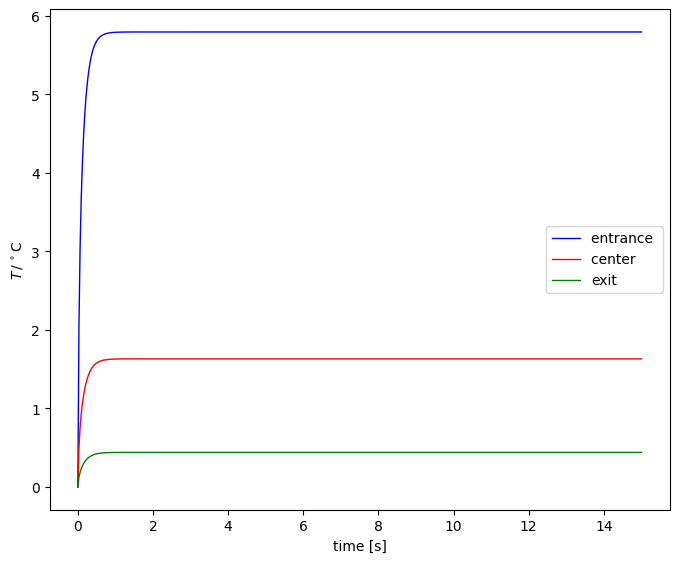

In [14]:
# plot center point temperature profiles at entrance and half-length
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals, T_entrance, 'b-', lw = 1, label = 'entrance ')
ax.plot(t_vals, T_center,'r-', lw = 1, label = 'center ')
ax.plot(t_vals, T_exit, 'g-', lw = 1, label = 'exit')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
print('t_off: %s seconds' %t_off)
ax.legend() 
fig.show()
print('max temperature; entrance: %.6s [degC], longitudinal center: %.6s [degC]' %(np.max(T_entrance), np.max(T_center)))

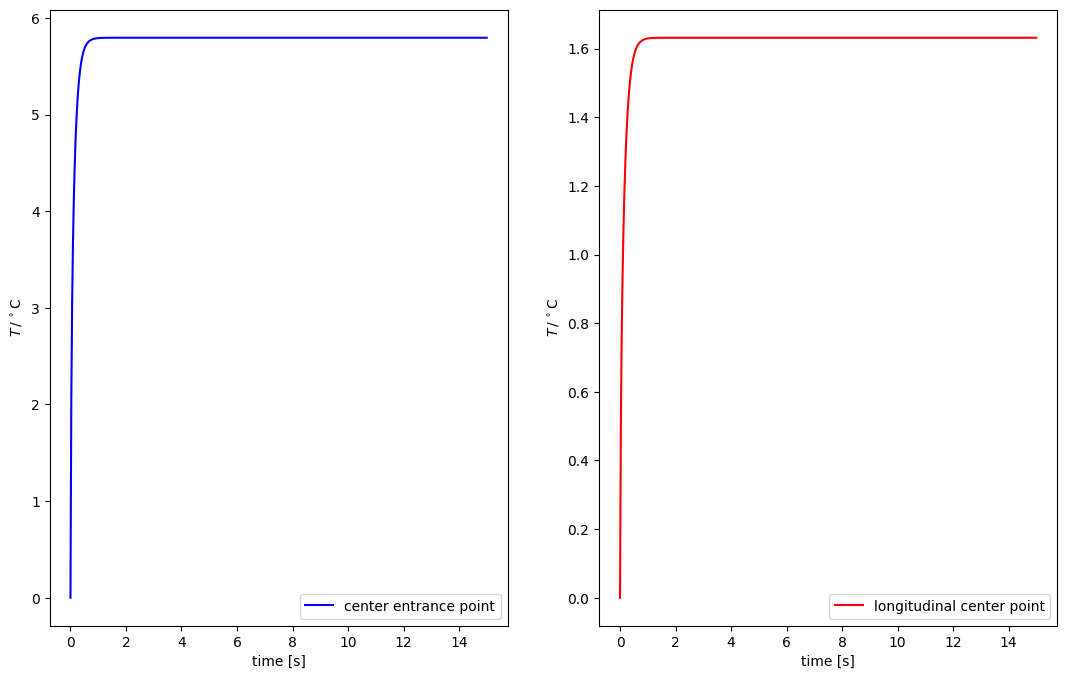

In [15]:
fig = plt.figure(figsize=(13,8))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(t_vals, T_entrance,'b-', lw = 1.5, label = 'center entrance point')
fig2.plot(t_vals, T_center,'r-', lw = 1.5, label = 'longitudinal center point')
fig1.legend()
fig2.legend()

fig1.set_xlabel(r'time [s]')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_xlabel(r'time [s]')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

fig.show()

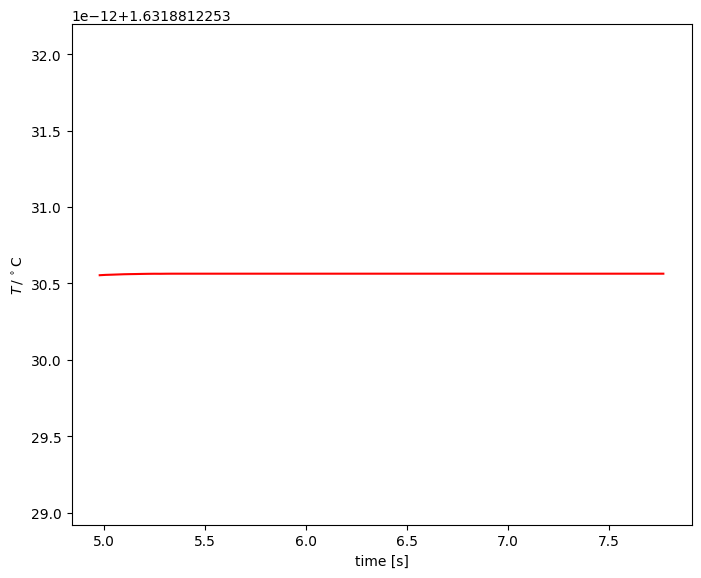

In [16]:
# create arrays for T_center(t) and T_ent(t) and t for decay region
decay_ran_min = 166     # min index value of decay data range    for 1000 time steps: (8 for 2.5 s)  (16 for 5 s)  
decay_ran_max = 260     # max index value of decay data range    for 1000 time steps: (20 for 2.5 s)  (23 for 5 s)  
T_center_decay = T_center[decay_ran_min:decay_ran_max]
T_entrance_decay = T_entrance[decay_ran_min:decay_ran_max]
T_exit_decay = T_exit[decay_ran_min:decay_ran_max]
t_vals_decay = t_vals[decay_ran_min:decay_ran_max]

T_entrance_decay = np.array(T_entrance_decay)
T_center_decay = np.array(T_center_decay)
T_exit_decay = np.array(T_exit_decay)
t_vals_decay = np.array(t_vals_decay)

# plot center longitudinal point decay profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals_decay, T_center_decay,'r-', lw = 1.5, label = 'longitudinal center point')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
# ax.legend()
fig.show()

In [17]:
# exp fit function
# def exp_fit(x, A, B, C):
#     y = A * np.exp((-B) * x) + C
#     return y
def exp_fit(x, A, B):
    y = A * np.exp((-B) * x)
    return y

In [18]:
params = (T_center_decay[0], 0.07)

In [19]:
parameters_Tcen, covariance_Tcen = curve_fit(exp_fit, t_vals_decay, T_center_decay, p0 = params, maxfev=2000)
parameters_Tent, covariance_Tent = curve_fit(exp_fit, t_vals_decay, T_entrance_decay, p0 = params, maxfev=2000)
parameters_Texit, covariance_Texit = curve_fit(exp_fit, t_vals_decay, T_exit_decay, p0 = params, maxfev=2000)

fit_A_Tcen = parameters_Tcen[0]
fit_B_Tcen = parameters_Tcen[1]
fit_A_Tent = parameters_Tent[0]
fit_B_Tent = parameters_Tent[1]
fit_A_Texit = parameters_Texit[0]
fit_B_Texit = parameters_Texit[1]
# fit_C_Tcen = parameters_Tcen[2]

fit_y_Tcen = exp_fit(t_vals_decay, fit_A_Tcen, fit_B_Tcen)
fit_y_Tent = exp_fit(t_vals_decay, fit_A_Tent, fit_B_Tent)
fit_y_Texit = exp_fit(t_vals_decay, fit_A_Texit, fit_B_Texit)
# fit_y_Tcen = exp_fit(t_vals_decay, fit_A_Tcen, fit_B_Tcen, fit_C_Tcen)

# calculate time constant, tau
tau_Tcen = 1 / fit_B_Tcen
tau_Tent = 1 / fit_B_Tent
tau_Texit = 1 / fit_B_Texit

$\hspace{13mm}$ T(t) = 5.796e+00  exp(--0.000t)

$\hspace{13mm}$ $\tau $ = -1005198036069 ms

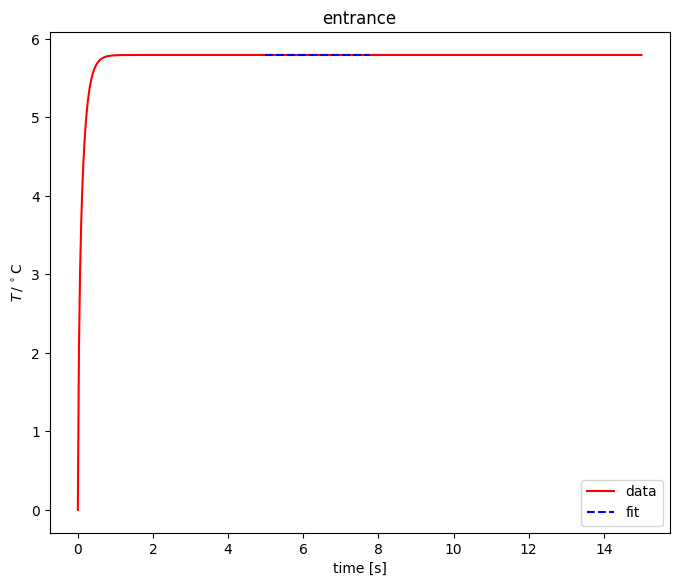

In [20]:
# plot axial entrance point decay profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals, T_entrance,'r-', lw = 1.5, label = 'data')
ax.plot(t_vals_decay, fit_y_Tent,'b--', linewidth = 1.5, label = 'fit')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
ax.legend()
plt.title('entrance')
 
printmd('$\hspace{13mm}$ T(t) = %.3e  exp(-%.3ft)' %(fit_A_Tent, fit_B_Tent))
printmd(r'$\hspace{13mm}$ $\tau $ = %.0f ms' %(tau_Tent*1e3))
# printmd('$\hspace{13mm}$ A = %.3e $\hspace{10mm}$ B = %.3f' %(fit_A_Tcen, fit_B_Tcen))
# printmd('$\hspace{13mm}$ A = %.5f $\hspace{10mm}$ B = %.5f $\hspace{9mm}$ C = %.5f ' %(fit_A_Tcen, fit_B_Tcen, fit_C_Tcen))

fig.show()

$\hspace{13mm}$ T(t) = 1.632e+00  exp(--0.000t)

$\hspace{13mm}$ $\tau $ = -902369892976 ms

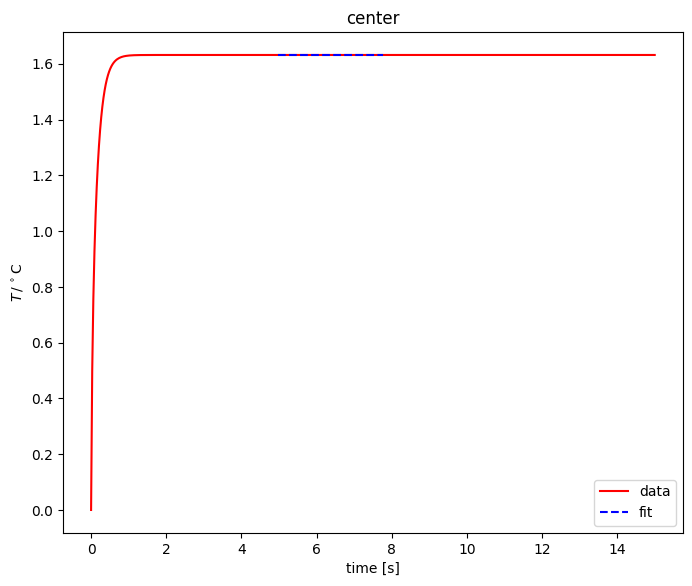

In [21]:
# plot axial center point decay profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals, T_center,'r-', lw = 1.5, label = 'data')
ax.plot(t_vals_decay, fit_y_Tcen,'b--', linewidth = 1.5, label = 'fit')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
ax.legend()
plt.title('center')
 
printmd('$\hspace{13mm}$ T(t) = %.3e  exp(-%.3ft)' %(fit_A_Tcen, fit_B_Tcen))
printmd(r'$\hspace{13mm}$ $\tau $ = %.0f ms' %(tau_Tcen*1e3))
# printmd('$\hspace{13mm}$ A = %.3e $\hspace{10mm}$ B = %.3f' %(fit_A_Tcen, fit_B_Tcen))
# printmd('$\hspace{13mm}$ A = %.5f $\hspace{10mm}$ B = %.5f $\hspace{9mm}$ C = %.5f ' %(fit_A_Tcen, fit_B_Tcen, fit_C_Tcen))

fig.show()

$\hspace{13mm}$ T(t) = 4.405e-01  exp(--0.000t)

$\hspace{13mm}$ $\tau $ = -1774354478997 ms

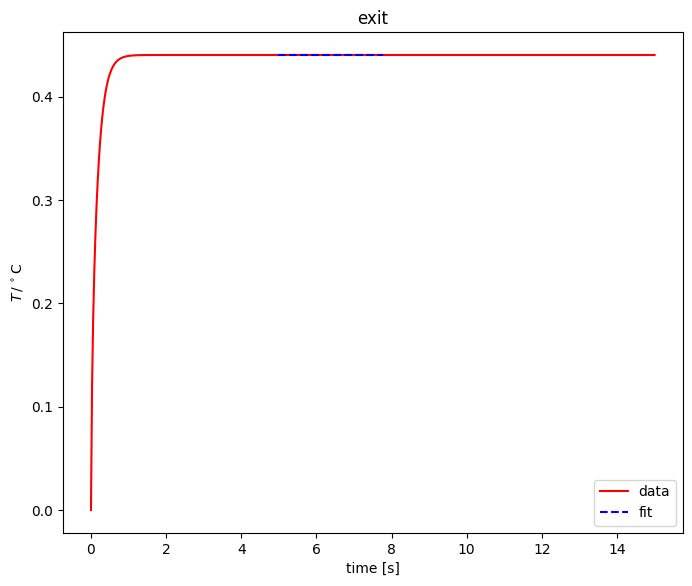

In [22]:
# plot axial exit point decay profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals, T_exit,'r-', lw = 1.5, label = 'data')
ax.plot(t_vals_decay, fit_y_Texit,'b--', linewidth = 1.5, label = 'fit')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
ax.legend()
plt.title('exit')
 
printmd('$\hspace{13mm}$ T(t) = %.3e  exp(-%.3ft)' %(fit_A_Texit, fit_B_Texit))
printmd(r'$\hspace{13mm}$ $\tau $ = %.0f ms' %(tau_Texit*1e3))
# printmd('$\hspace{13mm}$ A = %.3e $\hspace{10mm}$ B = %.3f' %(fit_A_Tcen, fit_B_Tcen))
# printmd('$\hspace{13mm}$ A = %.5f $\hspace{10mm}$ B = %.5f $\hspace{9mm}$ C = %.5f ' %(fit_A_Tcen, fit_B_Tcen, fit_C_Tcen))

fig.show()

$\hspace{13mm}$ T(t) = 5.796e+00  exp(--0.000t)

$\hspace{13mm}$ $\tau $ = -1005198036069 ms

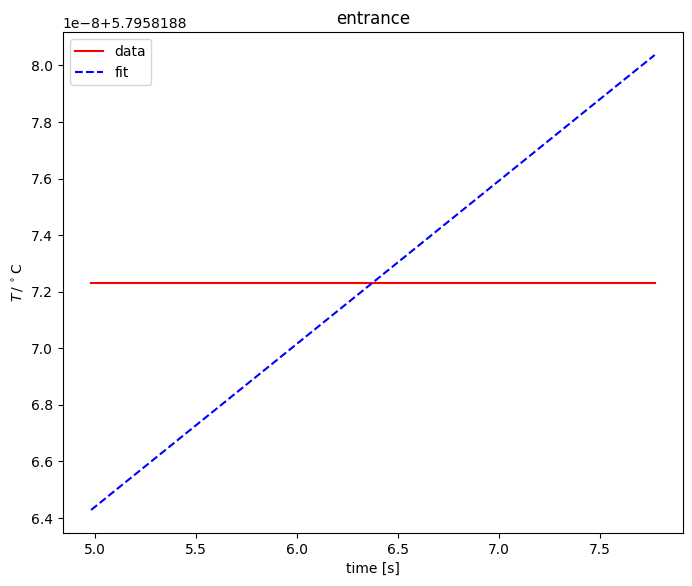

In [23]:
# plotaxial entrance point decay profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals_decay, T_entrance_decay,'r-', lw = 1.5, label = 'data')
ax.plot(t_vals_decay, fit_y_Tent,'b--', linewidth = 1.5, label = 'fit')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
ax.legend()
plt.title('entrance')
 
printmd('$\hspace{13mm}$ T(t) = %.3e  exp(-%.3ft)' %(fit_A_Tent, fit_B_Tent))
printmd(r'$\hspace{13mm}$ $\tau $ = %.0f ms' %(tau_Tent*1e3))
# printmd('$\hspace{13mm}$ A = %.3e $\hspace{10mm}$ B = %.3f' %(fit_A_Tcen, fit_B_Tcen))
# printmd('$\hspace{13mm}$ A = %.5f $\hspace{10mm}$ B = %.5f $\hspace{9mm}$ C = %.5f ' %(fit_A_Tcen, fit_B_Tcen, fit_C_Tcen))

fig.show()

$\hspace{13mm}$ T(t) = 1.632e+00  exp(--0.000t)

$\hspace{13mm}$ $\tau $ = -902369892976 ms

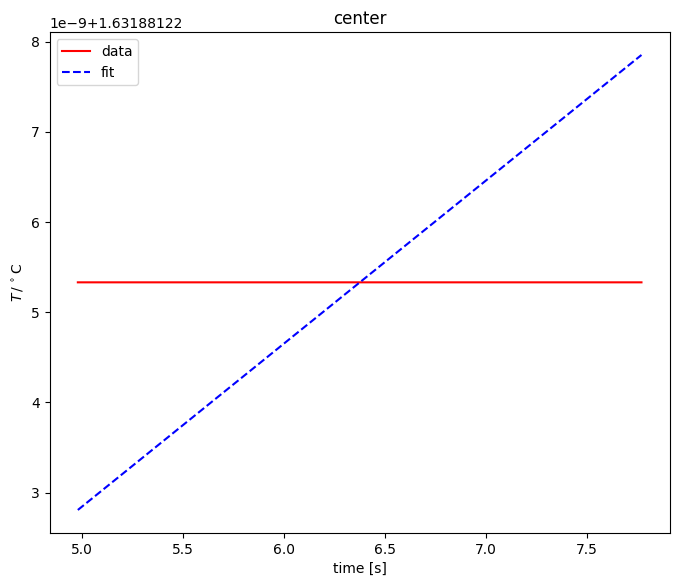

In [24]:
# plot axial center point decay profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals_decay, T_center_decay,'r-', lw = 1.5, label = 'data')
ax.plot(t_vals_decay, fit_y_Tcen,'b--', linewidth = 1.5, label = 'fit')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
ax.legend()
plt.title('center')

printmd(r'$\hspace{13mm}$ T(t) = %.3e  exp(-%.3ft)' %(fit_A_Tcen, fit_B_Tcen))
printmd(r'$\hspace{13mm}$ $\tau $ = %.0f ms' %(tau_Tcen*1e3))
# printmd('$\hspace{13mm}$ A = %.3e $\hspace{10mm}$ B = %.3f' %(fit_A_Tcen, fit_B_Tcen))
# printmd('$\hspace{13mm}$ A = %.5f $\hspace{10mm}$ B = %.5f $\hspace{9mm}$ C = %.5f ' %(fit_A_Tcen, fit_B_Tcen, fit_C_Tcen))

fig.show()

In [25]:
# create t_vals and T_entrance_decay vals with more points for decay time constant calculation using exponential fit equation
n_decay_calc = 150     # no. of points for decay time constant calculation
t_vals_decay_calc = np.linspace(np.min(t_vals_decay), np.max(t_vals_decay), n_decay_calc)

T_entrance_decay_calc = []

for j in range(len(t_vals_decay_calc)):
    T_entrance_decay_calc_val = 3.232e4 * np.exp(-3.031 * t_vals_decay_calc[j])
    T_entrance_decay_calc.append(T_entrance_decay_calc_val)
    
# print(T_entrance_decay_calc)

$\hspace{13mm}$ T(t) = 5.796e+00  exp(--0.000t)

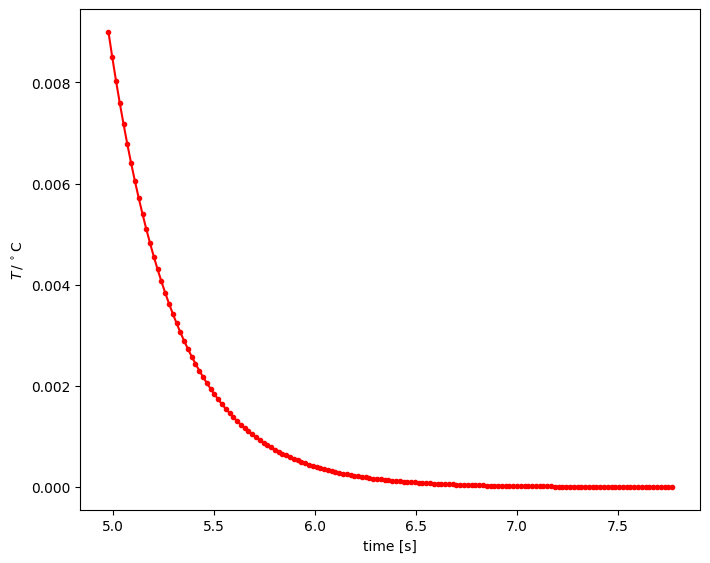

In [26]:
# plot center entrance point decay profile - calculated with n_decay_calc points using exponential fit equation
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(t_vals_decay_calc, T_entrance_decay_calc,'r.-', lw = 1.5, label = 'data')
# ax.plot(t_vals_decay, fit_y_Tent,'b--', linewidth = 1.5, label = 'fit')
# ax.vlines(t_vals, 0, T_center, linestyle="dashed")
# ax.axvline(x=t_off, color='k', ls='--')
# ax.axvline(x=0.015, color='k', ls='--')
ax.set_xlabel(r'time [s]')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
# ax.legend()
 
printmd('$\hspace{13mm}$ T(t) = %.3e  exp(-%.3ft)' %(fit_A_Tent, fit_B_Tent))
# printmd(r'$\hspace{13mm}$ $\tau $ = %.0f ms' %(tau_Tent*1e3))
# printmd('$\hspace{13mm}$ A = %.3e $\hspace{10mm}$ B = %.3f' %(fit_A_Tcen, fit_B_Tcen))
# printmd('$\hspace{13mm}$ A = %.5f $\hspace{10mm}$ B = %.5f $\hspace{9mm}$ C = %.5f ' %(fit_A_Tcen, fit_B_Tcen, fit_C_Tcen))

fig.show()

In [27]:
# calculate time constant for temperature decay at crystal entrance
# https://www.mmc.co.jp/adv/dev/english/document/thermistor/thermistor08.html

T1_entrance = T_entrance_decay_calc[0]                              # Temperature at shut off, T_1
T2_entrance = T_entrance_decay_calc[n_decay_calc - 1]               # Temperature at cool down, T_2
T_tau_entrance = 0.632 * (T2_entrance - T1_entrance) + T1_entrance  # Temperature at time constant
printmd(r'$\hspace{13mm}$ Temperature at time constant, $T_{\tau}$ = %.3f degC' %(T_tau_entrance))
printmd('$\hspace{13mm}$ T(t) = %.3e  exp(-%.3ft)' %(fit_A_Tent, fit_B_Tent))

$\hspace{13mm}$ Temperature at time constant, $T_{\tau}$ = 0.003 degC

$\hspace{13mm}$ T(t) = 5.796e+00  exp(--0.000t)

In [28]:
idx

501

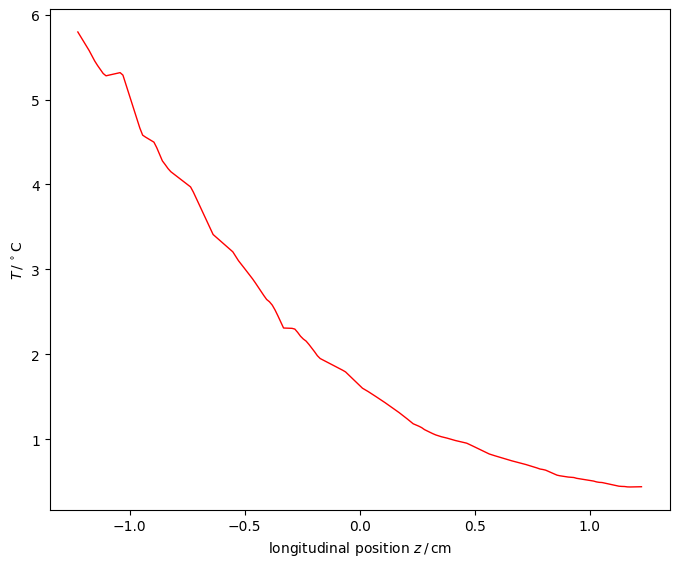

In [29]:
# plot longitudinal temperature profile
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(zv, uz,'r-', lw = 1)
ax.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
ax.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig.show()

***
$\textbf{Calculate longitudinal average of transverse temperatures and find quadratic fits for n slices}$

#### Extract longitudinal temp data for range of radii.

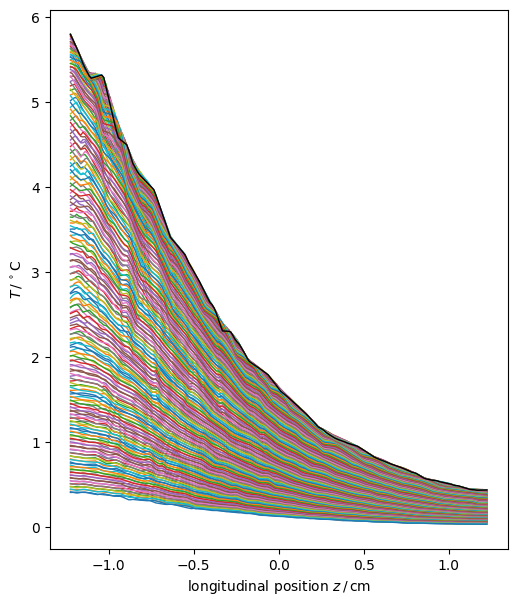

In [30]:
# note:
# throws an error to evaluate at the limits of radpts -
# reduce the value of radpts by some factor, rad_fac
rad_fac = 0.9
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
uz_array = np.zeros((len(radpts), len(zv)))
for j in range(len(radpts)):
    uz_array[j] = [u(pt) for pt in [(radpts[j][0]*rad_fac, 0, z_) for z_ in zv]]
    # print(np.shape(uz_array))
    fig1.plot(zv, uz_array[j], lw=1)
    # fig1.plot(zv, uz_array[j], lw=1, label='{0:5.1f}'.format(radpts[j][0]*.9))
fig1.plot(zv, uz, 'k', lw=1)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
# fig1.legend()
fig.show()

In [31]:
print(np.shape(uz_array))
# print(uz_array[10])

(201, 201)


##### Uncomment next few cells for optical path length calculation (will overwrite uz_array from temperature values to refractive index values)

In [32]:
# # uz_array = np.zeros((len(radpts), len(zv)))
# fig = plt.figure(figsize=(13,7))
# fig1 = fig.add_subplot(n_rows, n_cols, 1)
# for j in range(len(radpts)):
#     uz_array[j] = 13e-6 * uz_array[j] + 1.75991
#     # uz_array[j] = [u(pt) for pt in [(radpts[j][0]*rad_fac, 0, z_) for z_ in zv]]
#     fig1.plot(zv, uz_array[j], lw=1)
#     # fig1.plot(zv, uz_array[j], lw=1, label='{0:5.1f}'.format(radpts[j][0]*.9))

In [33]:
# dz = (zv[len(zv) - 1] - zv[0]) / (len(zv) - 1)

# n_int_array = []
# for i in range((len(radpts) - 0)):
#     n_int_val = (np.sum(uz_array[i]) - 0.5 * (uz_array[i][0] + uz_array[i][-1])) * dz
#     n_int_array.append(n_int_val)

In [34]:
# print(np.shape(n_int_array))
# print(n_int_array)

In [35]:
# fig = plt.figure(figsize=(13,7))
# fig1 = fig.add_subplot(n_rows, n_cols, 1)
# # fig2 = fig.add_subplot(n_rows, n_cols, 2)

# fig1.plot(radpts, n_int_array,'b-', lw = 1, ms = 2)
# # fig1.plot(radpts_x_laser, fit_yq_int0,'b--', linewidth = 2, label = 'fit')
# fig1.set_xlabel(r'$r \ [\mathrm{cm}]$')
# fig1.set_ylabel(r'$\int n(r,z) \, \mathrm{d}z \ [\mathrm{cm}]$')
# # fig1.set_ylim(0, 10)
# # fig1.legend()

# fig.show()

### Divide data into n longitudinal slices.

In [74]:
n_uz = 128                            # no. of longitudinal slices
n_uz_tot = len(radpts) - 1           # total no. of longitudinal profiles in uz_array
print('total no. of longitudinal profiles in uz_array:', n_uz_tot)

# extract only r_x vals from radpts
radpts_array = np.array(radpts)
radpts_x = radpts_array[:,0]
print('shape of radpts_x:', np.shape(radpts_x))

# print(uz_array[:,0:n_uz])
# print('shape of uz_array[0:n_uz,:]:', np.shape(uz_array[0:n_uz,:]))
# print('shape of zv:', np.shape(zv))
# print('shape of zv[0:n_uz]:', np.shape(zv[0:n_uz]))

dslice_ind = int(n_uz_tot/n_uz)                 # size of of slice indeces
print('size of slice indices, dslice_ind:', dslice_ind)

for i in range(0,5):
    globals()['x'+str(i)] = i
    
    # print(x1)
print(x0)
print(x1)


total no. of longitudinal profiles in uz_array: 200
shape of radpts_x: (201,)
size of slice indices, dslice_ind: 1
0
1


In [75]:
for j in range(n_uz - 1):
    
    # print(j + 1)
    uz_array0 = np.transpose(uz_array[:,0:dslice_ind])
    zv_array0 = zv[0:dslice_ind]
    radpts_x0 = radpts_array[0:dslice_ind,:]  
    
    globals()['uz_array'+str(j + 1)] = np.transpose(uz_array[:,(dslice_ind*(j+1)):(dslice_ind*(j+2))])
    globals()['zv_array'+str(j + 1)] = zv[(dslice_ind*j):(dslice_ind*(j+1))]
    globals()['radpts_x'+str(j + 1)] = radpts_array[(dslice_ind*j):(dslice_ind*(j+1)),:] 


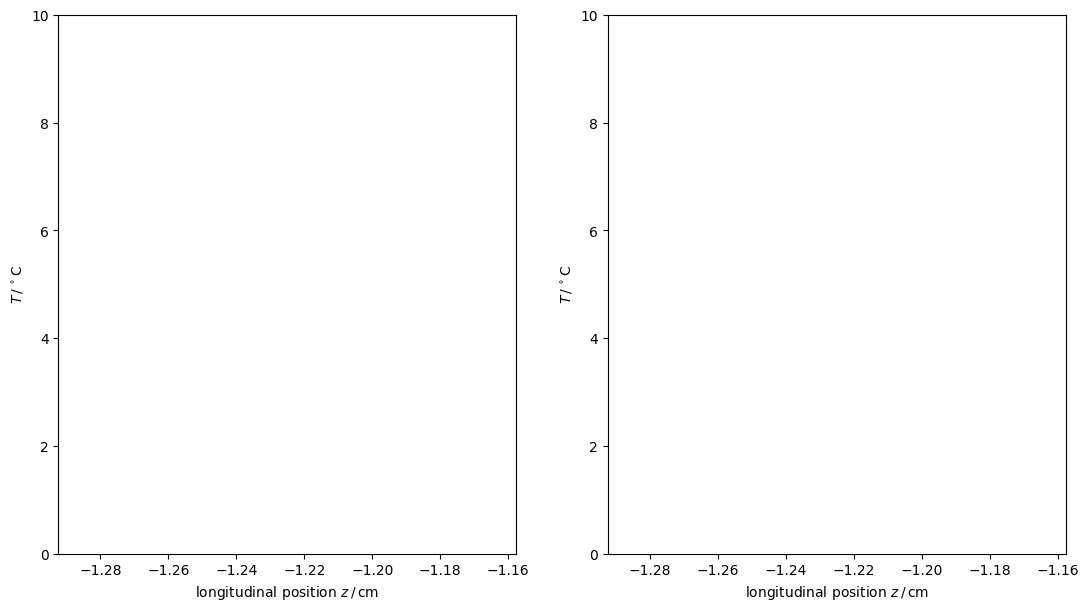

In [76]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(zv_array0, uz_array0, lw=1)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig1.set_ylim(0, 10)


fig2.plot(zv_array1, uz_array1, lw=1)
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_ylim(0, 10)
# fig1.legend()

fig.show()

# print(uz_array[0:n_uz,:])
# print('shape of uz_array[0:n_uz,:]:', np.shape(uz_array[0:n_uz,:]))

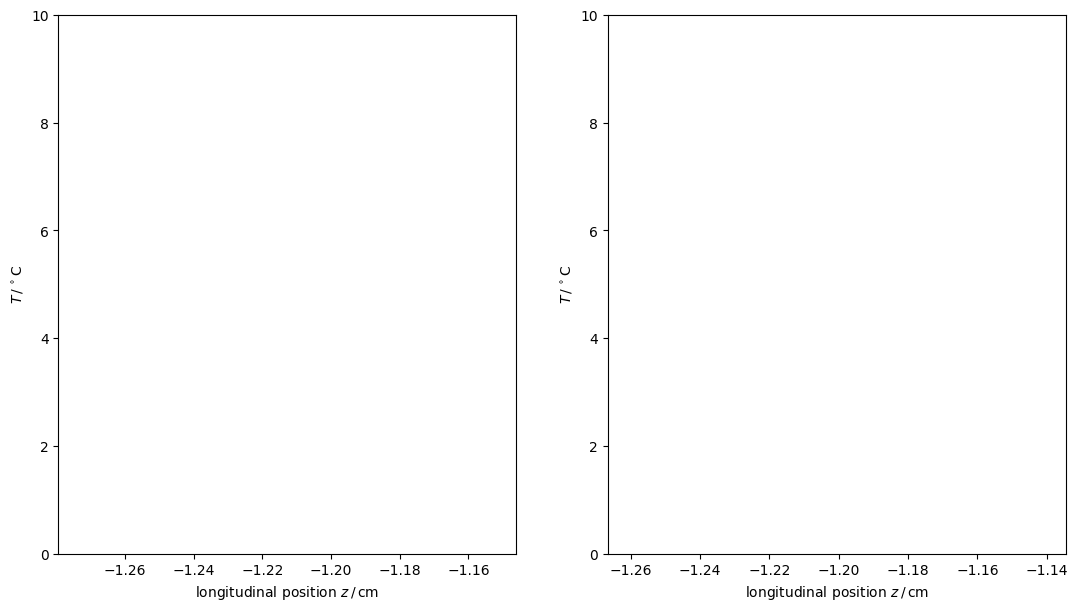

In [77]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(zv_array2, uz_array2, lw=1)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig1.set_ylim(0, 10)


fig2.plot(zv_array3, uz_array3, lw=1)
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')
fig2.set_ylim(0, 10)
# fig1.legend()

fig.show()

# print(uz_array[0:n_uz,:])
# print('shape of uz_array[0:n_uz,:]:', np.shape(uz_array[0:n_uz,:]))

### Integrate longitudinal temperature profiles

In [78]:
# calculate longitudinal step size, dz
dz = (zv[len(zv) - 1] - zv[0]) / (len(zv) - 1)
print('dz: %.7s cm' %(dz))

for j in range(n_uz):
    globals()['t_int_vals'+str(j)] = []
    # print(j)
    for i in range((len(radpts_x) - 0)):
    # print('j + 1:', j + 1)
    
        globals()['t_int'+str(j)] = np.sum(globals()['uz_array'+str(j)][:,i]) * dz / (leng / n_uz)
        # print(t_int0)
        # print(t_int1)
        globals()['t_int_vals'+str(j)].append(globals()['t_int'+str(j)])
        # t_int0 = np.sum(uz_array0[:,j]) * dz / (leng / n_uz)  # divide by n_uz because leng is now only 1/n_uz*leng_total
        # t_int_vals0.append(t_int0)

dz: 0.01225 cm


In [79]:
# create arrays for T_int(r) and r for region within laser radius
laser_ran_min = 49 # 49      # min index value of center data range
laser_ran_max = 152 # 152    # max index value of center data range
radpts_x_laser = radpts_x[laser_ran_min:laser_ran_max]

In [80]:
for j in range(n_uz):
    globals()['t_int_vals'+str(j)+str('laser')] = globals()['t_int_vals'+str(j)][laser_ran_min:laser_ran_max]
    # t_int_vals0_laser = t_int_vals0[laser_ran_min:laser_ran_max]

In [81]:
# quad fit function
def quad_int0(x, A, B):
    y = A*x**2 + B
    return y

In [82]:
for j in range(n_uz):
    
    globals()['parameters_q_int'+str(j)], globals()['covariance_q_int'+str(j)] = curve_fit(quad_int0, radpts_x_laser, globals()['t_int_vals'+str(j)+str('laser')])
    
    globals()['fit_Aq_int'+str(j)] = globals()['parameters_q_int'+str(j)][0]
    globals()['fit_Bq_int'+str(j)] = globals()['parameters_q_int'+str(j)][1]
    
    globals()['fit_yq_int'+str(j)] = quad_int0(radpts_x_laser, globals()['fit_Aq_int'+str(j)], globals()['fit_Bq_int'+str(j)])
    
#     parameters_q_int0, covariance_q_int0 = curve_fit(quad_int0, radpts_x_laser, t_int_vals0_laser)

#     fit_Aq_int0 = parameters_q_int0[0]
#     fit_Bq_int0 = parameters_q_int0[1]

#     fit_yq_int0 = quad_int0(radpts_x_laser, fit_Aq_int0, fit_Bq_int0)

$\hspace{13mm}$ $T_{int} = -32.24257 r^2 + 3.48540$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = -31.94458 r^2 + 3.47490$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

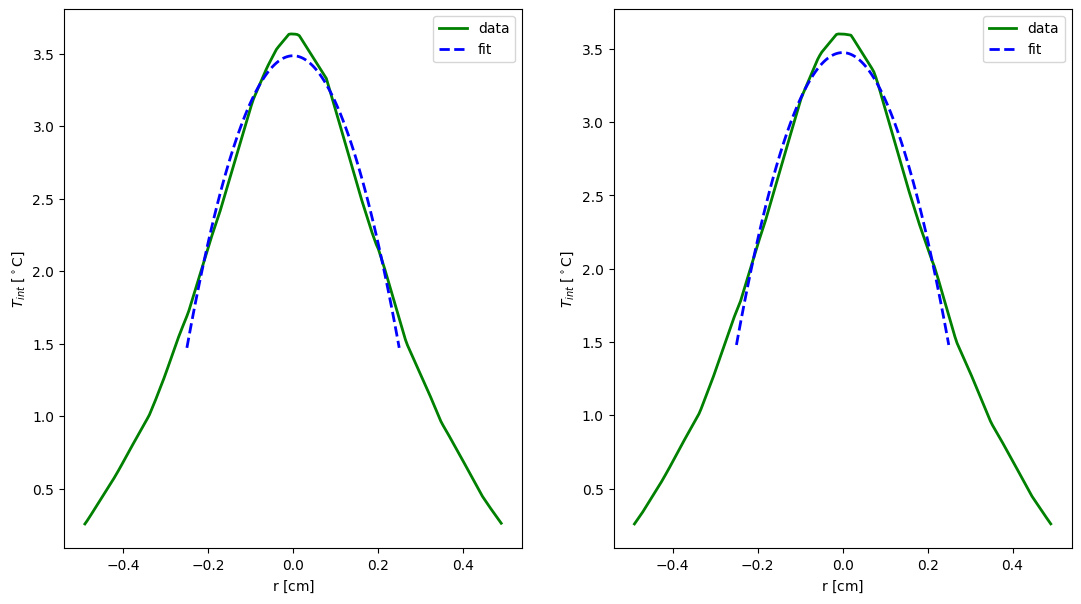

In [83]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, t_int_vals0,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_int0,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig1.set_ylim(0, 10)
fig1.legend()


fig2.plot(radpts_x, t_int_vals1,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_int1,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig2.set_ylim(0, 10)
fig2.legend()

fig.show()

printmd('$\hspace{13mm}$ $T_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_int0, fit_Bq_int0, fit_Aq_int1, fit_Bq_int1))

$\hspace{13mm}$ $T_{int} = -31.51365 r^2 + 3.45950$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = -31.00889 r^2 + 3.43851$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

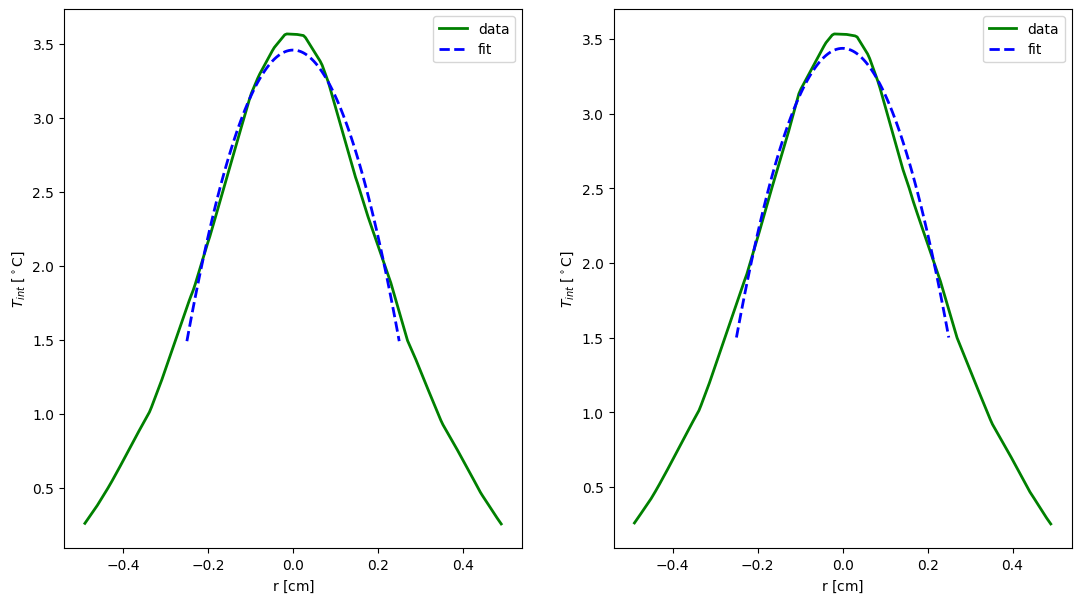

In [84]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, t_int_vals2,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_int2,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig1.set_ylim(0, 6)
fig1.legend()


fig2.plot(radpts_x, t_int_vals3,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_int3,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$T_{int}$ $[{}^\circ\mathrm{C}]$')
# fig2.set_ylim(0, 6)
fig2.legend()

fig.show()

printmd('$\hspace{13mm}$ $T_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $T_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_int2, fit_Bq_int2, fit_Aq_int3, fit_Bq_int3))

### Calculate index of refraction for each slice

In [85]:
#calculate n_int vals from t_int_vals
chi_T = 1.28e-5
# chi_T taken from:
# Thermal lens effect model of Ti:sapphire for use in
# high-power laser amplifiers - Jeong 2018
# expression for n(T) taken from:
# Tapping 1986
for j in range(n_uz):
    globals()['n_int_vals'+str(j)] = []
    for i in range(len(t_int_vals0)):
        globals()['n_int'+str(j)] = 1.75991 + (chi_T * globals()['t_int_vals'+str(j)][i]) + (3.1e-9 * globals()['t_int_vals'+str(j)][i]**2)
        
        globals()['n_int_vals'+str(j)].append(globals()['n_int'+str(j)])

In [86]:
# create arrays for n_int(r) for region within laser radius and apply quadratic fit
for j in range(n_uz):
    globals()['n_int_vals' + str(j) + '_laser'] = globals()['n_int_vals' + str(j)][laser_ran_min:laser_ran_max]
    globals()['parameters_q_intn' + str(j)], globals()['covariance_q_intn' + str(j)] = curve_fit(quad_int0, radpts_x_laser, globals()['n_int_vals' + str(j) + '_laser'])
    globals()['fit_Aq_intn' + str(j)] = globals()['parameters_q_intn' + str(j)][0]
    globals()['fit_Bq_intn' + str(j)] = globals()['parameters_q_intn' + str(j)][1]
    globals()['fit_yq_intn' + str(j)] = quad_int0(radpts_x_laser, globals()['fit_Aq_intn' + str(j)], globals()['fit_Bq_intn' + str(j)])
    
# extract n0 and n2 values
n2_vals = []
n0_vals = []

for j in range (n_uz):
    n2_vals.append(globals()['fit_Aq_intn' + str(j)])
    n0_vals.append(globals()['fit_Bq_intn' + str(j)])

# fix negative n2 vals and ****divide through by 2 based on Gaussian duct definition n(r) = n0 - 1/2*n2*r^2**** - see rp-photonics.com
n2_vals = np.multiply(n2_vals, -0.5)
print(n2_vals)

[2.06623044e-04 2.04712132e-04 2.01948489e-04 1.98719157e-04
 1.95723038e-04 1.93015265e-04 1.90877312e-04 1.88999271e-04
 1.86720976e-04 1.84314430e-04 1.82933862e-04 1.83141143e-04
 1.83566319e-04 1.83275334e-04 1.82397015e-04 1.79215670e-04
 1.76758057e-04 1.75834277e-04 1.74628144e-04 1.73078476e-04
 1.70821857e-04 1.67648828e-04 1.63639948e-04 1.59932898e-04
 1.59300720e-04 1.57558428e-04 1.53512695e-04 1.48507345e-04
 1.45142878e-04 1.43630463e-04 1.42731111e-04 1.42571471e-04
 1.40909725e-04 1.38607664e-04 1.37062238e-04 1.35751220e-04
 1.34793074e-04 1.32967945e-04 1.31444067e-04 1.30334694e-04
 1.28839111e-04 1.27850406e-04 1.26425341e-04 1.23991721e-04
 1.22576118e-04 1.21095417e-04 1.19146166e-04 1.16649638e-04
 1.15176845e-04 1.14383756e-04 1.13537344e-04 1.12730428e-04
 1.11554109e-04 1.10082883e-04 1.08516877e-04 1.07048879e-04
 1.06136158e-04 1.05101497e-04 1.02916332e-04 1.00061517e-04
 9.76702393e-05 9.59261695e-05 9.45969042e-05 9.33961829e-05
 9.19692383e-05 9.106638

$\hspace{13mm}$ $n_{int} = -0.00041 r^2 + 1.75995$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $n_{int} = -0.00041 r^2 + 1.75995$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}

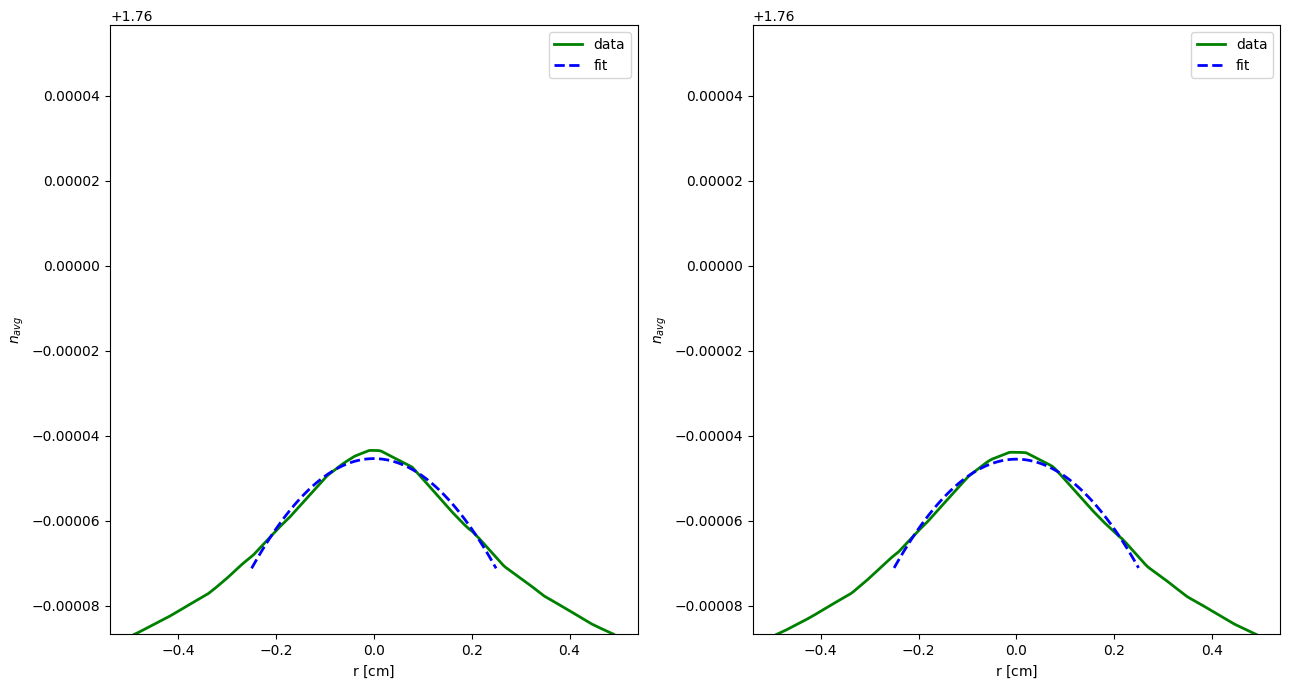

In [87]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(radpts_x, n_int_vals0,'g-', linewidth = 2, label = 'data')
fig1.plot(radpts_x_laser, fit_yq_intn0,'b--', linewidth = 2, label = 'fit')
fig1.set_xlabel(r'r $[\mathrm{cm}]$')
fig1.set_ylabel(r'$n_{avg}$')
fig1.set_ylim(np.min(n_int_vals0), np.max(n_int_vals0) + 1e-4)
fig1.legend()


fig2.plot(radpts_x, n_int_vals1,'g-', linewidth = 2, label = 'data')
fig2.plot(radpts_x_laser, fit_yq_intn1,'b--', linewidth = 2, label = 'fit')
fig2.set_xlabel(r'r $[\mathrm{cm}]$')
fig2.set_ylabel(r'$n_{avg}$')
fig2.set_ylim(np.min(n_int_vals0), np.max(n_int_vals0) + 1e-4)
# fig2.set_ylim(np.min(n_int_vals1), np.max(n_int_vals1))
fig2.legend()

fig.tight_layout()
fig.show()

printmd('$\hspace{13mm}$ $n_{int} = %.5f r^2 + %.5f$ $\hspace{10mm}$ z {-0.5 cm, 0.0 cm} $\hspace{9mm}$ $n_{int} = %.5f r^2 + %.5f$  $\hspace{10mm}$ z {0.0 cm, 0.5 cm}' %(fit_Aq_intn0, fit_Bq_intn0, fit_Aq_intn1, fit_Bq_intn1))

In [88]:
l_vals = []
n_int_max_vals = []
for j in range(n_uz):
    n_int_max_val = np.max(globals()['n_int_vals'+str(j)])
    n_int_max_vals.append(n_int_max_val)
    l_val = (leng/n_uz)*j + (0.5 * (leng/n_uz))
    l_vals.append(l_val)

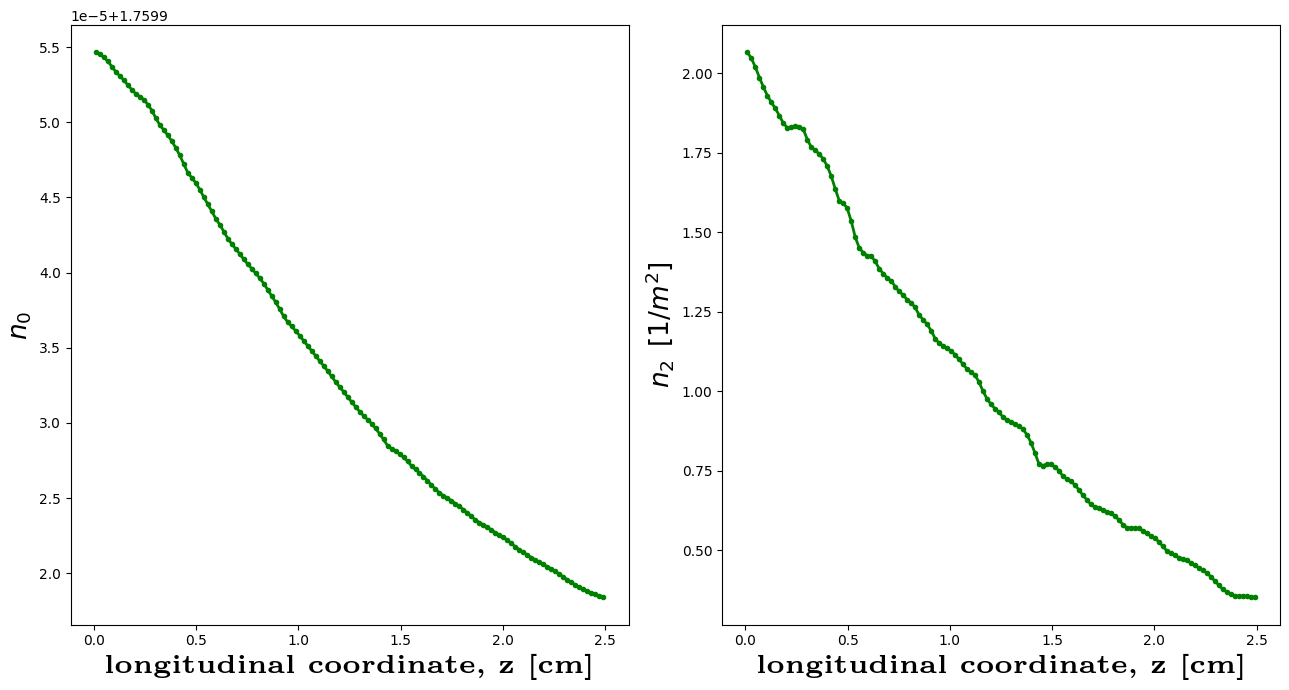

In [89]:
fig = plt.figure(figsize=(13,7))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(l_vals, n0_vals,'g.-', linewidth = 2)
fig1.set_xlabel(r'longitudinal coordinate, z [cm]',**hfontMed)
fig1.set_ylabel(r'$n_0$',**hfontMed)
# fig1.set_ylim(0, 6)
# fig1.legend()

fig2.plot(l_vals, np.multiply(n2_vals, 1e4),'g.-', linewidth = 2)
fig2.set_xlabel(r'longitudinal coordinate, z [cm]',**hfontMed)
fig2.set_ylabel(r'$n_2$ $[1/m^2]$',**hfontMed)
# fig2.set_ylim(0, 6)
# fig2.legend()

fig.tight_layout()
fig.show()

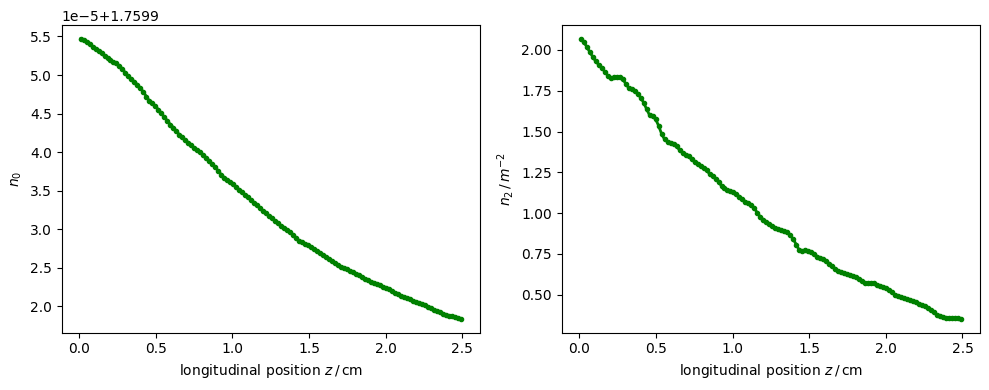

In [90]:
fig = plt.figure(figsize=(10,4))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(l_vals, n0_vals,'g.-', linewidth = 2)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig1.set_ylabel(r'$n_0$')
# fig1.set_ylim(0, 6)
# fig1.legend()

fig2.plot(l_vals, np.multiply(n2_vals, 1e4),'g.-', linewidth = 2)
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
fig2.set_ylabel(r'$n_2\,/\,{}m^{-2}$')
# fig2.set_ylim(0, 6)
# fig2.legend()

# fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
# fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

fig.tight_layout()
fig.savefig('refractive_index_long_profiles.png')
fig.show()

In [91]:
print('n2_entrance: %s [1/m^2]' %(n2_vals[0]*1e4))

n2_entrance: 2.066230442589109 [1/m^2]


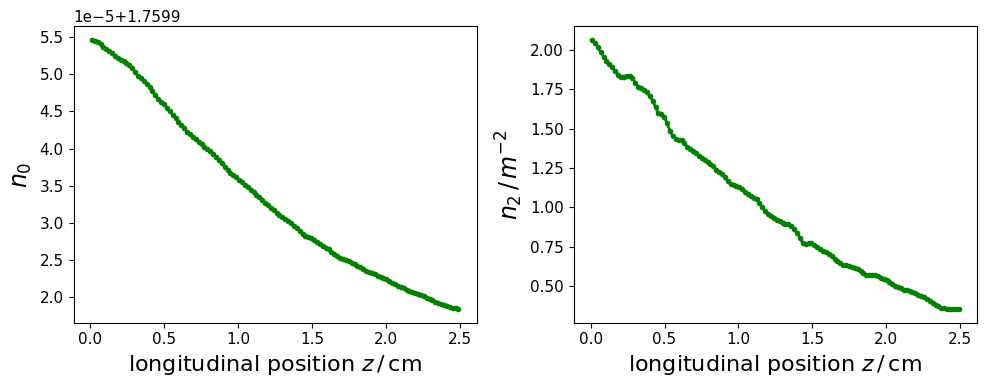

In [92]:
# plot n0 and n2 with increased label font sizes
SMALL_SIZE = 11
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

fig = plt.figure(figsize=(10,4))
fig1 = fig.add_subplot(n_rows, n_cols, 1)
fig2 = fig.add_subplot(n_rows, n_cols, 2)

fig1.plot(l_vals, n0_vals,'g.-', linewidth = 2)
fig1.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$', fontsize = 16)
fig1.set_ylabel(r'$n_0$', fontsize = 17)
# fig1.set_ylim(0, 6)
# fig1.legend()

fig2.plot(l_vals, np.multiply(n2_vals, 1e4),'g.-', linewidth = 2)
fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$', fontsize = 16)
fig2.set_ylabel(r'$n_2\,/\,{}m^{-2}$', fontsize = 17)
# fig2.set_ylim(0, 6)
# fig2.legend()

# fig2.set_xlabel(r'longitudinal position $z\,/\,\mathrm{cm}$')
# fig2.set_ylabel(r'$T\,/\,{}^\circ\mathrm{C}$')

fig.tight_layout()
fig.savefig('refractive_index_long_profiles.png')
fig.show()

#### ABCD matrix calculation

<img src="figures/gaussian_duct_abcd_mat01.png">

In [93]:
# calculate z (longitudinal length) for each slice of the crystal
leng_slice = leng / n_uz
print('leng_slice: %g [cm]' %(leng_slice))

leng_slice: 0.0195312 [cm]


In [94]:
# extract n0 and n2 values
gamma_vals = np.zeros(n_uz)
for j in range (n_uz):
    gamma_val = np.sqrt(n2_vals[j] / n0_vals[j])
    gamma_vals[j] = gamma_val

In [95]:
# calculate ABCD matrices for each crystal slice and store inside abcd_mats[]
abcd_mats = np.zeros((n_uz, 2, 2))

for j in range (n_uz):
    gamma_z = gamma_vals[j] * leng_slice
    abcd_mats[j, 0, 0] = np.cos(gamma_z)
    abcd_mats[j, 0, 1] = (1 / n0_vals[j] / gamma_vals[j]) * np.sin(gamma_z)
    abcd_mats[j, 1, 0] = (- (n0_vals[j] * gamma_vals[j])) * np.sin(gamma_z)
    abcd_mats[j, 1, 1] = np.cos(gamma_z)
    
print(abcd_mats[15, :, :])

[[ 9.99999981e-01  1.10976147e-02]
 [-3.50030604e-06  9.99999981e-01]]


In [96]:
# test multiplication order of np.matmul()
# a_mat = np.array([[1, 1], [0, 1]])
# b_mat = np.array([[1, 0], [1, 1]])
# ab_mat = np.matmul(a_mat, b_mat)
# print(ab_mat)

In [97]:
# calculate total ABCD matrix by multiplying matrices for individual slices in order M_n-1 * M_n-2 * ... * M_0

abcd_mat_tot_full = np.array( [[1, 0], [0, 1]] )  # initialize total ABCD mat as identity for first multiplication with M_n-1

for j in range (n_uz):
        abcd_mat_tot_full = np.matmul(abcd_mat_tot_full, abcd_mats[n_uz - j - 1, :, :])
        
printmd('$M_{ABCD}$: %s' %(abcd_mat_tot_full))

$M_{ABCD}$: [[ 9.99766109e-01  1.42042473e+00]
 [-2.57171148e-04  9.99868568e-01]]

##### ABCD Matrix convergence study

In [98]:
# construct matrices from less slices by keeping only data every downsample factor from n0 and n2 arrays

ds_fac = 10     # downsample factor, e.g. ds_fac = 3, every third value taken

for j in range(ds_fac - 1):
    globals()['n0_vals_' + str(j + 2)] = n0_vals[::(j + 2)]
    globals()['n2_vals_' + str(j + 2)] = n2_vals[::(j + 2)]
    
    globals()['leng_slice_' + str(j + 2)] = leng / n_uz * (j + 2)

    # globals()['gamma_vals_' + str(j + 2)] = np.sqrt(n2_vals[::(j + 2)] / n0_vals[::(j + 2)])
    globals()['gamma_vals_' + str(j + 2)] = np.sqrt(globals()['n2_vals_' + str(j + 2)] / globals()['n0_vals_' + str(j + 2)])
    
    current_arr_size = np.size(globals()['gamma_vals_' + str(j + 2)])
    print(current_arr_size)
    # globals()['gamma_z']
    
    globals()['abcd_mats_' + str(j + 2)] = np.zeros((current_arr_size, 2, 2))
    
    for k in range(current_arr_size):
        gamma_z = globals()['gamma_vals_' + str(j + 2)][k] * globals()['leng_slice_' + str(j + 2)]
        globals()['abcd_mats_' + str(j + 2)][k, 0, 0] = np.cos(gamma_z)
        globals()['abcd_mats_' + str(j + 2)][k, 0, 1] = (1 / globals()['n0_vals_' + str(j + 2)][k] / globals()['gamma_vals_' + str(j + 2)][k]) * np.sin(gamma_z)
        globals()['abcd_mats_' + str(j + 2)][k, 1, 0] = (- (globals()['n0_vals_' + str(j + 2)][k] * globals()['gamma_vals_' + str(j + 2)][k])) * np.sin(gamma_z)
        globals()['abcd_mats_' + str(j + 2)][k, 1, 1] = np.cos(gamma_z)

    
    
print(np.shape(abcd_mats_2))
print(np.shape(abcd_mats_4))
print(np.shape(abcd_mats_6))
    

    
    
    
# print(np.shape(gamma_vals_2))
# print(np.shape(gamma_vals_4))
# print(np.shape(n0_vals_2))
# print(np.shape(n0_vals_3))
# print(np.shape(n0_vals_4))
# print(np.shape(n0_vals_5))
# print(np.shape(n0_vals_6))
# print(leng_slice)
# print(leng_slice_2)
# print(leng_slice_3)
# print(leng_slice_4)


64
43
32
26
22
19
16
15
13
(64, 2, 2)
(32, 2, 2)
(22, 2, 2)


In [99]:
# calculate total ABCD matrix for each slice-downsampled set of matrices


abcd_mat_tot = np.zeros((ds_fac - 1, 2, 2))

for j in range(ds_fac - 1):
    # print(j)
    # globals()['abcd_mats_' + str(j + 2)][k, 0, 0]
    
    # abcd_mat_tot[j, :, :]
    
    # current_arr_size = np.size(globals()['gamma_vals_' + str(j + 2)])
    current_arr_size = np.size(globals()['gamma_vals_' + str(j + 2)])
    
    abcd_mat_tot[j, :, :] = np.array( [[1, 0], [0, 1]] )
    for k in range(current_arr_size):
        abcd_mat_tot[j, :, :] = np.matmul(abcd_mat_tot[j , :, :], globals()['abcd_mats_' + str(j + 2)][current_arr_size - k - 1, :, :])


print(abcd_mat_tot_full)
print(abcd_mat_tot[0, :, :])
print(abcd_mat_tot[1, :, :])
print(abcd_mat_tot[2, :, :])
print(abcd_mat_tot[3, :, :])
print(abcd_mat_tot[4, :, :])

[[ 9.99766109e-01  1.42042473e+00]
 [-2.57171148e-04  9.99868568e-01]]
[[ 9.99764639e-01  1.42042403e+00]
 [-2.58888056e-04  9.99867599e-01]]
[[ 9.99760304e-01  1.43151965e+00]
 [-2.61281210e-04  9.99865635e-01]]
[[ 9.99761819e-01  1.42042267e+00]
 [-2.62215885e-04  9.99865692e-01]]
[[ 9.99754464e-01  1.44261455e+00]
 [-2.65323546e-04  9.99862743e-01]]
[[ 9.99746922e-01  1.46480643e+00]
 [-2.68457892e-04  9.99859803e-01]]


In [100]:
sum_sq_diff_arr = []

for j in range (ds_fac - 1):
    abcd_mat_diff = abcd_mat_tot_full - abcd_mat_tot[j, :, :]
    sum_sq_diff = np.square(abcd_mat_diff[0, 0]) + np.square(abcd_mat_diff[0, 1]) + np.square(abcd_mat_diff[1, 0]) + np.square(abcd_mat_diff[1, 1])
    sum_sq_diff_arr.append(sum_sq_diff)
    
print(sum_sq_diff_arr)

[6.535555461432015e-12, 0.0001230973037471024, 5.6362765916390704e-11, 0.0004923886213725752, 0.001969735745215582, 0.0030776939943087207, 2.9390109393248217e-10, 0.006032343377888745, 0.000492222439482539]


In [101]:
ds_vals_arr = np.linspace(2, ds_fac, ds_fac - 1)
print(ds_vals_arr)

[ 2.  3.  4.  5.  6.  7.  8.  9. 10.]


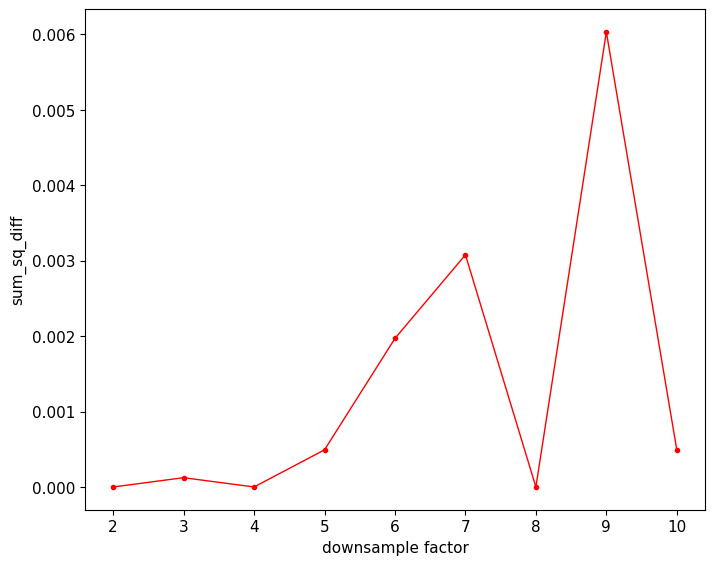

In [105]:
# plot sum of the squares of the difference between full and slice-downsampled total ABCD matrices
fig = plt.figure(figsize=(8,6.5))
ax = fig.gca()
ax.plot(ds_vals_arr, sum_sq_diff_arr,'r.-', lw = 1)
ax.set_xlabel(r'downsample factor')
ax.set_ylabel(r'sum_sq_diff')
# ax.set_yscale('log')
# ax.set_xscale('log')
fig.show()